In [98]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

import io
import PIL.Image, PIL.ImageDraw

import requests

import einops
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

# Notebook dependencies
from IPython.display import clear_output, Image

import importlib
import sys
importlib.reload(sys.modules['utils'])

from utils import *

device_id = 1
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

device is cuda:1


In [3]:
# Parameters

CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🛩"

# Load target image
target_img = load_emoji(TARGET_EMOJI)

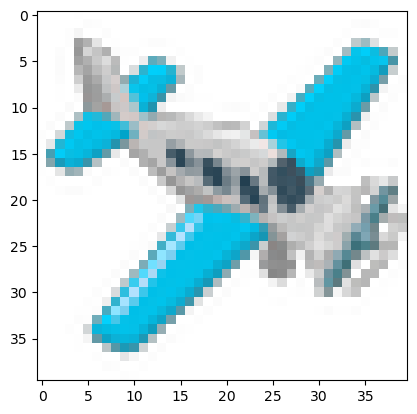

In [4]:
plt.imshow(target_img)
plt.show()

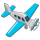

In [5]:
imshow(target_img)

In [6]:
# Define Model

class CAModel(nn.Module):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    conv1 = nn.Conv2d(in_channels=self.channel_n*3, out_channels=128, kernel_size=1)
    conv2 = nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    
    # Apply "do-nothing" initial behavior
    # torch.nn.init.xavier_uniform_(conv1.weight) # default to how tensorflow initializes the weights
    torch.nn.init.zeros_(conv2.weight)
    torch.nn.init.zeros_(conv1.bias)
    torch.nn.init.zeros_(conv2.bias)

    self.dmodel = nn.Sequential(
        conv1,
        nn.ReLU(),
        conv2,
    )
    
    # self.dmodel = nn.Sequential(
    #     nn.Conv2d(in_channels=self.channel_n*3, out_channels=128, kernel_size=1),
    #     nn.ReLU(),
    #     nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    # )

  def perceive(self, x, angle=0.0):
    """Pytorch does convolutions differently. Reshape accordingly
      input is (batch, in_channels, H, W)
      kernel is (filter_height, filter_width, in_channels, channel_multiplier) in TF
      but should be (out_channels, in_channels / groups, H, W) in Torch"""
    identify = torch.as_tensor([0, 1, 0], dtype=torch.float32)
    identify = torch.outer(identify, identify)
    dx = torch.as_tensor(np.outer([1, 2, 1], [-1, 0, 1]) / 8.0, dtype=torch.float32) # Sobel filter
    dy = dx.T
    c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
    stacked_filters = torch.stack((identify, c*dx-s*dy, s*dx+c*dy)).to(device)
    kernel = torch.repeat_interleave(stacked_filters, self.channel_n, dim=0).view(self.channel_n*3, 1, 3, 3)
    y = F.conv2d(x, kernel, padding='same', groups=self.channel_n)
    return y

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2)) # make it shape [batch_size, in_channels, H, W]
    # x = x.view(0, 3, 1, 2)
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle) # y should be on device
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = torch.rand(x[:, :1, :, :].shape, device=device, dtype=torch.float32) <= fire_rate
    x = x + dx * update_mask
    # x = x + dx

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)) # send it back [batch_size, H, W, in_channels]

CAModel().dmodel

Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)

seed shape is torch.Size([72, 72, 16])


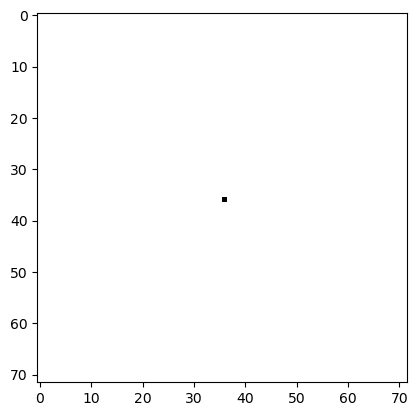

In [7]:
# Make training sample

p = TARGET_PADDING
target_img_tensor = torch.tensor(target_img)
pad_target = torch.nn.functional.pad(target_img_tensor, (0, 0, p, p, p, p))
h, w = pad_target.shape[:2]
seed = torch.zeros(h, w, CHANNEL_N, dtype=torch.float32)
seed[h//2, w//2, 3:] = 1.0
print(f'seed shape is {seed.shape}')

plt.imshow(seed[..., :4])
plt.show()

In [43]:
test_load = load_ca_model(CAModel, "vanilla_ca")

100%|███████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 501.24it/s]

batch (before/after):


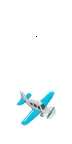

In [49]:
simulate_model(test_load, seed.unsqueeze(0), 80, device=device)

torch.Size([128, 48, 1, 1]) torch.Size([128]) torch.Size([16, 128, 1, 1]) torch.Size([16])


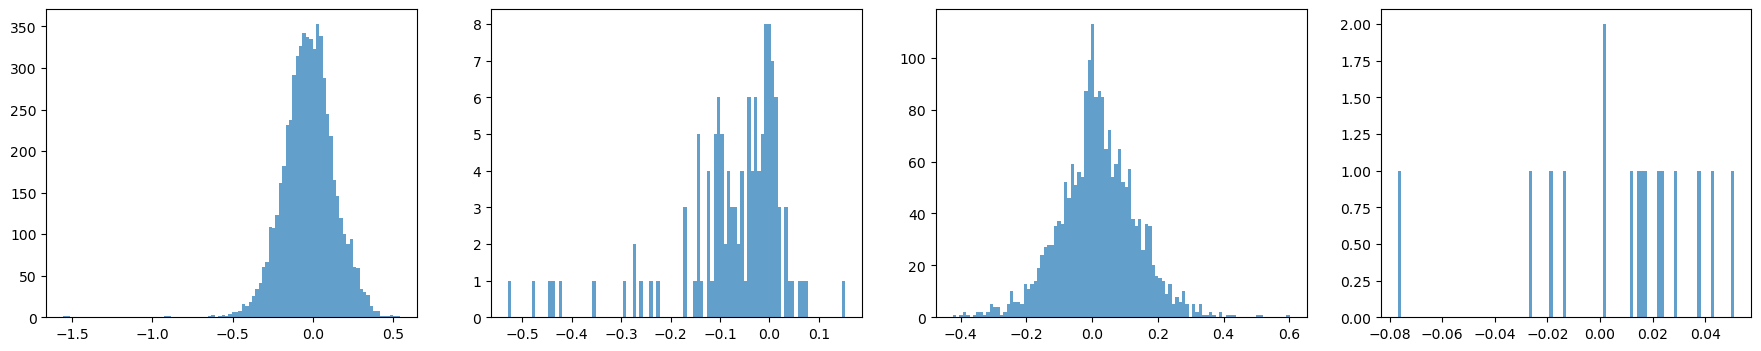

In [50]:
show_weights(test_load)

In [159]:
# Training Sequence

class Train:
  def __init__(self, ca_model, target, lr=2e-3):
    self.ca = ca_model
    self.target = einops.repeat(target, '... -> b ...', b=BATCH_SIZE)
    self.lr = lr
    # Initialize optimizer with lr scheduler
    self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr, weight_decay=1e-8)
    # self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr)
    # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optim, step_size=2000, gamma=0.1)
    # Use library MSELoss
    self.loss_f = nn.MSELoss()

    # Log the training progress
    self.loss_log = []

  def train(self, x0, n_steps=1001):
    "Just support Growing mode for now"

    for i in range(n_steps+1):

      # Run through a single training step of the model
      x, loss = self._train_step(x0)
      self.loss_log.append(loss)
      # print(f'loss log is {self.loss_log}')

      # Printing
      if i % 100 == 0:
        clear_output()

        # visualize batch
        visualize_batch(x0.detach().cpu(), x.detach().cpu(), i)
        
        # plot loss
        plot_loss(self.loss_log)
        # export model

      print('\r step: %d, log10(loss): %.3f'%(i, np.log10(loss)), end='')

    return self.loss_log
    
  def _train_step(self, x):
    """Perform the update step some random number of times"""
    iter_n = np.random.randint(64, 97, dtype=np.int32)
    # Clear previous gradients accumulated on parameters
    self.optim.zero_grad()
    for _ in range(iter_n):
      # Forward pass of model
      x = self.ca(x)

    # Compute loss
    loss = self.loss_f(to_rgba(x), self.target)
    # loss = self._loss_f(x, self.target).mean()

    # Compute gradients
    loss.backward()
    
    # Update parameters
    self.optim.step()
    
    # Update learning rate step
    # self.scheduler.step()

    return x, loss.item()

  def _loss_f(self, output, target):
    return torch.square(to_rgba(output) - target).mean(dim=(-2, -3, -1))


batch (before/after):


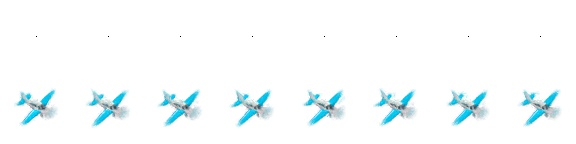

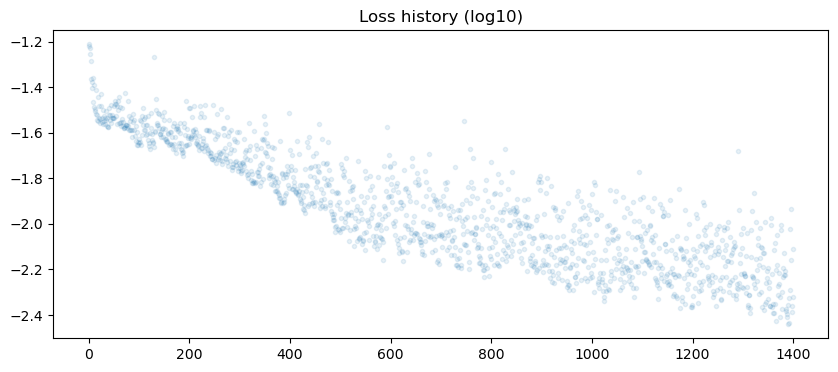

 step: 1402, log10(loss): -2.285

In [ ]:
%%time
# original torch conv layer initialization WITH weight decay

ca = CAModel().to(device)
train = Train(ca, pad_target.to(device))

x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log = train.train(x0.to(device), n_steps=4001)

In [55]:
save_ca_model(ca, "vanilla_ca_1")

Saved model vanilla_ca_1 to disk


In [112]:
del test_load

In [153]:
test_load = load_ca_model(CAModel, "vanilla_ca", device=device)

In [ ]:
def compare_model_weights(model1, model2):
    weights = []
    biases = []
    with torch.no_grad():
        for i, (m1, m2) in enumerate(zip(model1.modules(), model2.modules())):
            if isinstance(m1, nn.Conv2d) and isinstance(m2, nn.Conv2d):
                weight = m.state_dict()['weight']
                bias = m.state_dict()['bias']
                
                
                weights.append(weight)
                biases.append(bias)

    # Get individual weights
    weights1 = weights[0].detach().cpu()
    weights2 = weights[1].detach().cpu()
    bias1 = biases[0].detach().cpu()
    bias2 = biases[1].detach().cpu()

In [141]:
print(os.environ["CUDA_VISIBLE_DEVICES"]

KeyError: 'CUDA_VISIBLE_DEVICES'

In [140]:
! print $CUDA_VISIBLE_DEVICES

torch.Size([128, 48, 1, 1]) torch.Size([128]) torch.Size([16, 128, 1, 1]) torch.Size([16])


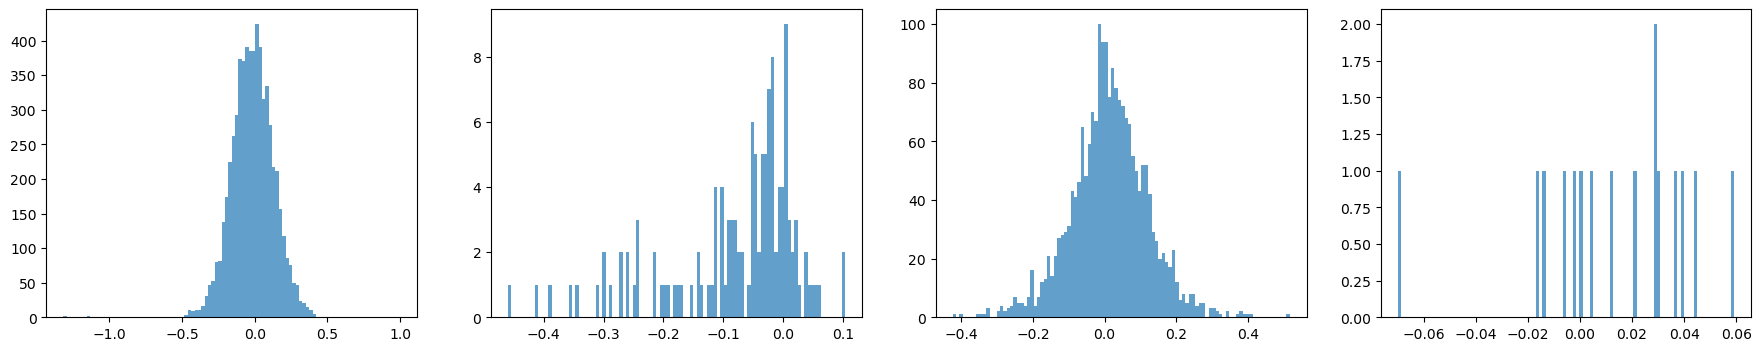

In [157]:
show_weights(ca)

torch.Size([128, 48, 1, 1]) torch.Size([128]) torch.Size([16, 128, 1, 1]) torch.Size([16])


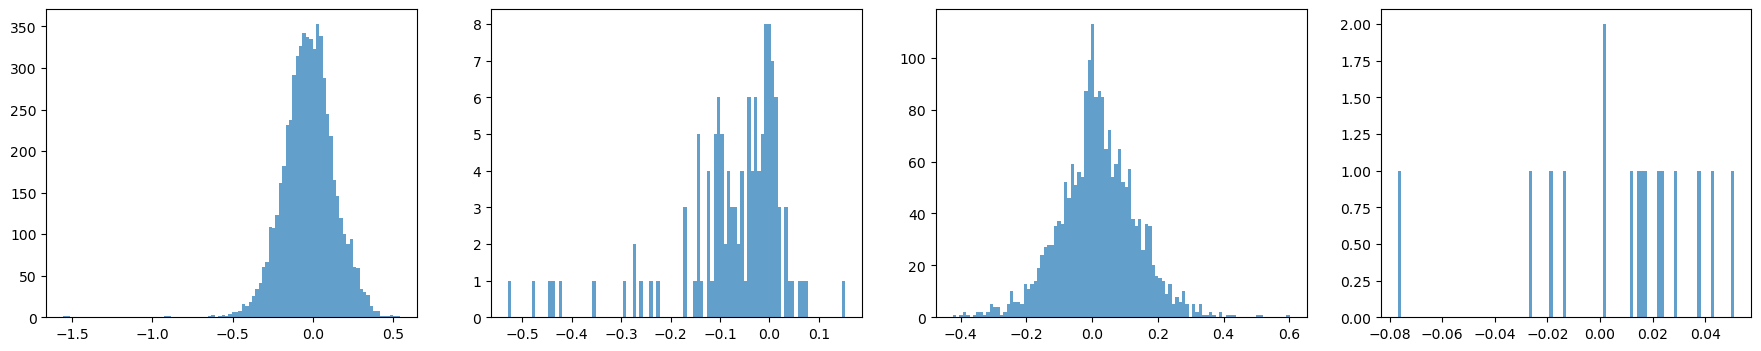

In [158]:
show_weights(test_load)

100%|███████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 495.85it/s]

batch (before/after):


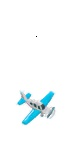

In [156]:
simulate_model(test_load, seed.unsqueeze(0), 80, device=device)

In [154]:
next(test_load.parameters()).device

device(type='cpu')

In [116]:
device

device(type='cuda', index=1)